# Домашнее задание

### МОВС. 2025-2026

### Анализ временных рядов

__Выдано:__ 02.12.2025

__Срок сдачи:__ 16.12.2025 23:59 MSK

```
Обратите внимание, что если у ассистента возникают подозрения по честному выполнению заданий (плагиат или использование LLM без указания промпта), то он может поставить вам устное собеседование по проделанной работе, по итогам которого он вправе обнулить вам работу.
```

В общем, когда вы читерите, то заставляете в мире плакать одного котенка и одного ассистента. Пожалейте их.

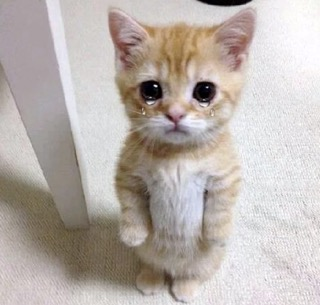

А теперь после такой грозной ноты — к более приятному.

Мы постарались составить домашнее задание так, чтобы оно помогло закрепить все то, что мы прошли на первых занятиях, посвященных классическим методам прогнозирования временных рядов. А также узнать пару новых сюжетов.

Сейчас мы будем работать со сгенерированным временным рядом, истинную форму которого вы не знаете, а мы знаем. Это все равно не значит, что мы будем знать, как построить идеальную модель (потому что в ряде есть артефакты, которые ни ETS-модель, ни SARIMA-модель не смогут до конца хорошо учесть), но мы сможем примерно оценить, а те ли компоненты и свойства ряда вы смогли примерно найти.

В бонусной части вы сможете поработать с реальным рядом и понять, насколько это больнее (а может и нет) :)

Также парочка бонусов будет раскидана по заданиям в основной части. Без бонусов можно набрать максимум 10 баллов, с бонусами — 15. При этом бонусы в сумме дают больше 5 баллов — вы можете выбирать, какие из них делать, а какие нет.

In [1]:
import random

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import statsmodels.api as sm
from matplotlib import pyplot as plt
from prophet import Prophet
from scipy import stats
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)


seed_everything()

**ПРЕДИСЛОВИЕ**  
Привет, проверяющий! Буду рад услышать комментарии, если я где-то что-то сделал не так.

Места, где я использовал LLM - я помечаю, что использовался DEEPSEEK. Зачастую это просто сокращение муторности (например, при обработке словаря в красивый датафрейм или для оформления графика).

Также предупреждаю - я использую автоформаттер, поэтому иногда код может выглядеть нечеловекоподобным, но это не я такой, это PEP8 такой :D

Спасибо за проверку!

### Задание 1. Первичный анализ данных (1 балл)

Для оценки качества прогнозирования будем использовать метрики MAE и MASE.

`Ответьте на вопрос (0.1 балл):` Что показывает метрика MASE и в чем ее отличие от просто MAE? В каких случаях ее использование предпочтительнее?

Мы уже с вами имплементировали метрики на одном из занятий, так что давайте просто их заберем оттуда.

In [3]:
def mase(
    forecast: np.ndarray,
    insample: np.ndarray,
    outsample: np.ndarray,
    frequency: int,
) -> np.ndarray:
    """MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    Args:
        forecast: Forecast values. Shape: batch, time_o
        insample: Insample values. Shape: batch, time_i
        outsample: Target values. Shape: batch, time_o
        frequency: Frequency value
    Returns:
        Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(forecast - outsample)) / np.mean(
        np.abs(insample[:-frequency] - insample[frequency:])
    )

Самым основным отличием в первую очередь хочется назвать то, что MAE - метрика абсолютная, а MASE относительная, что делает её более пригодной для интерпретирования результатов. Также MASE очень хорошо подходит именно для работы с временными рядами, так как имеет компонент со сдвигом (модуль разности значений тренировочного временного ряда со сдвигом на frequency). Параметр frequency позволяет корректно работать с сезонностью во временном ряде.

Показывает MASE насколько наша модель лучше наивного прогноза, где 0 - идеально, 1 - уровень наивного прогноза, а все, что выше - совсем плохо.

#### Задание 1.1: Загрузка данных (0 баллов)

Подгрузите данные из файла `synthetic_ts.csv`.

In [4]:
df = pd.read_csv(r"synthetic_ts.csv")
df.head()

,date,y
0,2000-01-31,10.000000
1,2000-02-29,9.709006
2,2000-03-31,13.652092
3,2000-04-30,15.152031
4,2000-05-31,9.847677


#### Задание 1.2: Типы данных (0.05 балла)

Выведите типы данных в датасете. Проверьте, что они корректные: даты должны быть в формате datetime, а значения — float. Если это не так, то исправьте их.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    300 non-null    object 
 1   y       300 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.8+ KB


In [6]:
df["date"] = pd.to_datetime(df["date"])

In [7]:
df.head()

,date,y
0,2000-01-31,10.000000
1,2000-02-29,9.709006
2,2000-03-31,13.652092
3,2000-04-30,15.152031
4,2000-05-31,9.847677


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    300 non-null    datetime64[ns]
 1   y       300 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.8 KB


Готово, дату поправили!)

#### Задание 1.3: Пропуски (0.05 балла)

Проверьте, есть ли в данных пропуски. Если они есть, то заполните их предыдущими значениями. Если пропусков нет, то просто выведите сообщение об этом.

In [9]:
df.isna().sum()

date    0
y       0
dtype: int64

Пропусков нет.

#### Задание 1.4: Визуальный анализ временных рядов (0.7 балла)

Постройте линейные графики временного ряда. По оси X отложите время, по оси Y — значения временного ряда.

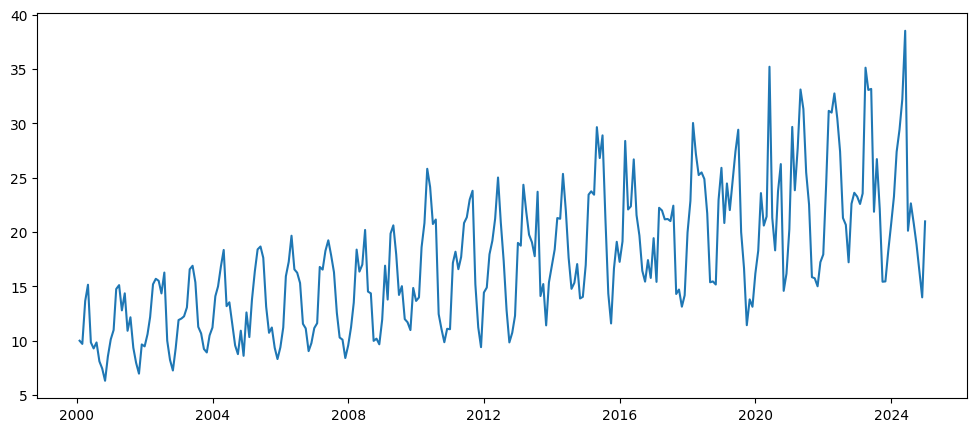

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["y"])
plt.show()

Уже видно, что график у нас нестационарный, значит в любом случае придется повозиться =)

Но и не случайные колебания во все стороны, на чем уже спасибо :D

Воспользуюсь DEEPSEEK для оформления графика.

In [11]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df["date"],
        y=df["y"],
        mode="lines+markers",
        marker=dict(size=6, symbol="circle"),
        hovertemplate="<b>Дата</b>: %{x|%Y-%m-%d %H:%M:%S}<br>"
        + "<b>Значение</b>: %{y:.2f}<extra></extra>",
    )
)

fig.update_layout(
    template="plotly_white",
    hovermode="x unified",
    xaxis_title="Дата",
    yaxis_title="Значение y",
    xaxis=dict(
        title_font=dict(size=14),
        tickfont=dict(size=12),
        tickformat="%Y-%m-%d",
        tickangle=-45,
    ),
    yaxis=dict(title_font=dict(size=14), tickfont=dict(size=12)),
    margin=dict(l=50, r=50, t=50, b=80),
)

fig.show()

`Ответьте на следующие вопросы:`
- Какова частотность (frequency) данных?
- Стационарен ли временной ряд? Если нет, то какие признаки нестационарности вы можете выделить?

Данные у нас есть за последнее число каждого месяца с 31 января 2000 года по 31 декабря 2024 года.  
Соответственно, частотность наших данных - 1 наблюдение в месяц.

На графике можно выделить тренд и сезонность, что не позволяет признать его стационарным. Периодичность сезонности - 12 точек (год).

Теперь постройте графики [автокорреляций (ACF)](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) и [частных автокорреляций (PACF)](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html) до 40-го лага для тренировочной выборки.

In [12]:
def plot_acf_pacf(data):
    fig, ax = plt.subplots(figsize=(8, 3))
    sm.graphics.tsa.plot_acf(data, lags=40, ax=ax)
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 3))
    sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax)
    plt.show()

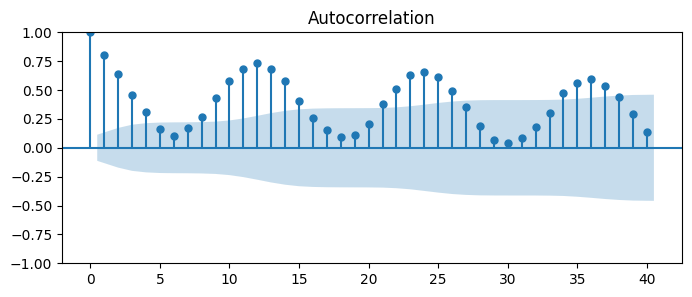

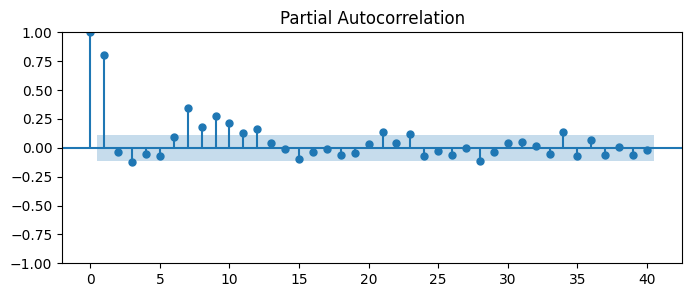

In [13]:
plot_acf_pacf(df["y"].values.squeeze())

`Ответьте на следующие вопросы:`
- Стационарен ли временной ряд?
- Присутствует ли в нём тренд? Сезонность? Цикличность?
- Если ряд сезонный, то какой период выглядит наиболее вероятным? Можем ли мы сказать, что сезонность аддитивная? Мультипликативная?

Ответы:
* Нет, временной ряд не стационарен. У него есть тренд и сезонность, что уже делает его не стационарным.
* Явно можно выделить восходящий тренд (среднее увеличивается между несоклькими соседними точками с течением времени), а также сезонность.
* Наиболее вероятным периодом я бы назвал 12 точек, т.е., 12 месяцев, т.е., год. Это не во всех случаях идеально так, но мы и живем не в идеальном мире, а график ACF достаточно хорошо подтверждает именно версию с периодом 12. Сезонность более похожа на мультипликативную, так как размах сезонных колебаний значительно увеличивается с течением времени.

#### Задание 1.5: Выделение тестовой выборки (0.1 балл)

Выделите 10% данных для теста, а остальные 90% оставьте для обучения.

`Ответьте на вопрос:` В чем особенность выделения тестовой выборки в задаче прогнозирования временных рядов?

In [14]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)

Особенность выделения тестовой выборки в том, что она обязательно должна быть после тренировочный по временным меткам. То есть, мы должны валидироваться на данных позднее тех, на которых мы учились. А также выборки не должны быть перемешаны и внутри себя - то есть, хронология дат доложна полностью сохраниться.

Например, в train_test_split от sklearn, который я тут использую, настроить это помогает атрибут shuffle=False, который выключает перемешивание выборок и тест у нас окажется после трейна и, что важно, в том же порядке.

### Задание 2. Стабилизация дисперсии временного ряда (2 балла + 1 бонусный балл)

На одном из занятий мы с вами обсуждали, что для стабилизации дисперсии временного ряда можно использовать преобразование Box-Cox. Давайте разберемся как оно работает. Помним, что Box-Cox нельзя использовать для отрицательных значений, но у нас их и нет.

#### Задание 2.1: Имплементация Box-Cox (1 балл)

Реализуйте прямую и обратную трансформацию Box-Cox (пользоваться готовым решением нельзя!). 

Прямое преобразование Box–Cox:

$$
z = g(y;\lambda) =
\begin{cases}
\dfrac{y^{\lambda} - 1}{\lambda}, & \lambda \ne 0, \\[6pt]
\log y, & \lambda = 0.
\end{cases}
$$

Обратное преобразование Box–Cox:

$$
y = g^{-1}(z;\lambda) =
\begin{cases}
(\lambda z + 1)^{1/\lambda}, & \lambda \ne 0, \\[6pt]
e^{z}, & \lambda = 0.
\end{cases}
$$


`БОНУС (1 балл):` Выведите формулы для обратного преобразования Box-Cox. Можно прикрепить к домашнему заданию файл с решением. Или сюда фотку. Или же ЗаТеХаТь.

Набивал руку техания весь курс математики для анализа данных, пришло время и тут знаки доллара порисовать :D

При $\lambda \ne 0$:
$$
z_1 = \dfrac{y_1^{\lambda} - 1}{\lambda}
$$
$$
y_1^{\lambda} - 1 = \lambda z_1
$$
$$
y_1^{\lambda} = \lambda z_1 + 1
$$
$$
(y_1^{\lambda})^{(1/\lambda)} = (\lambda z_1 + 1)^{(1/\lambda)}
$$
$$
y_1 = (\lambda z_1 + 1)^{1/\lambda}
$$
При $\lambda = 0$:
$$
z_2 = \log{y_2} 
$$
$$
y_2 = e^{z_2}
$$

In [15]:
def box_cox(x: np.ndarray, lam: float) -> np.ndarray:
    if lam != 0:
        res = (x ** (lam) - 1) / lam
    else:
        res = np.log(x)
    return res


def inv_box_cox(y: np.ndarray, lam: float) -> np.ndarray:
    if lam != 0:
        res = (lam * y + 1) ** (1 / lam)
    else:
        res = np.exp(y)
    return res

Проверьте, что `(inv_box_cox(box_cox(x, lam), lam))` примерно восстанавливает исходный массив x.

In [16]:
lam = 1
check_1 = inv_box_cox(box_cox(df["y"], lam), lam)
print(
    (df["y"].apply(lambda x: round(x, 4)) == check_1.apply(lambda x: round(x, 4))).sum()
)

lam = 0
check_2 = inv_box_cox(box_cox(df["y"], lam), lam)
print(
    (df["y"].apply(lambda x: round(x, 4)) == check_2.apply(lambda x: round(x, 4))).sum()
)

300
300


С округлением восстанавливает корректно, без него при lam 0 получается всего 107 совпадений. Ну, получается, ошибки округления

#### Задание 2.2: Подбор параметра λ (1 балл)

Перебор параметры $\lambda$ в боевых условиях происходит с помощью максимизации логарифма правдоподобия ([The optimal lambda parameter for minimizing skewness is estimated on each feature independently using maximum likelihood](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)). 

Но давайте пойдем более простым путем: переберите 3-4 значения $\lambda$ в диапазоне от -2 до 2. Постройте графики полученных рядов и визуально оцените, при каком $\lambda$ дисперсия выглядит наиболее стабильной. 

Переберите еще несколько значений $\lambda$ рядом с тем, которое показалось вам лучшим.

`Ответьте на вопрос:` Как $\lambda$ влияет на вид преобразованного ряда?

Ответ: 
* При отрицательных значениях ряд преобразуется до очень малых значений, правая сторона (конец ряда) сильно сглаживается, а левая остается со значительно большей диспрсией.
* При положительных значениях - наоборот размах значений ряда значительно выше, дисперсия выше в конце ряда, а начало очень сглажно до минимальной дисперсии.

In [17]:
def plot_box_cox(lam: float, y):
    transformed_data = box_cox(y, lam)
    plt.figure(figsize=(10, 3))
    plt.plot(transformed_data)
    plt.show()

lambda = -2


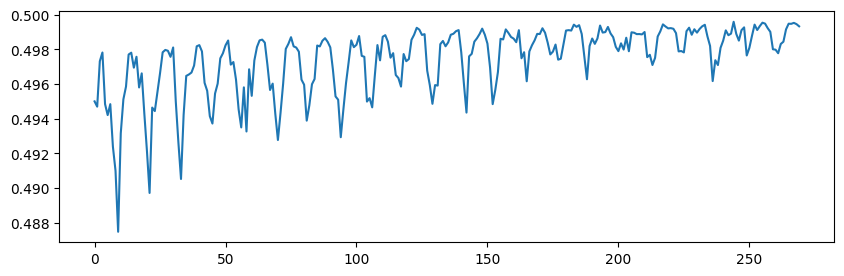

lambda = -1


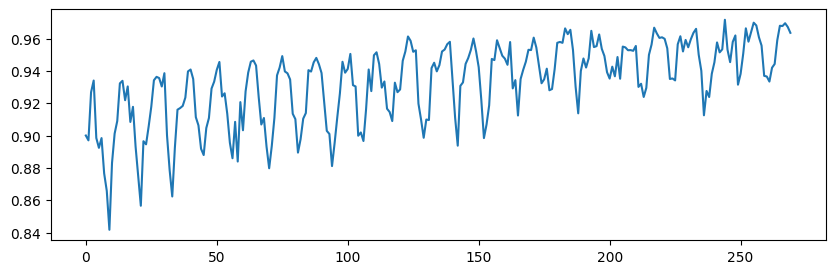

lambda = 0


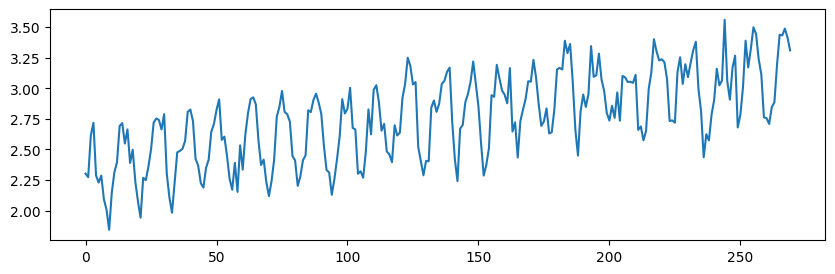

lambda = 1


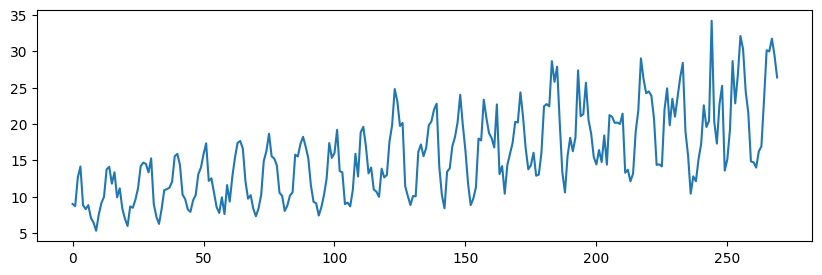

lambda = 2


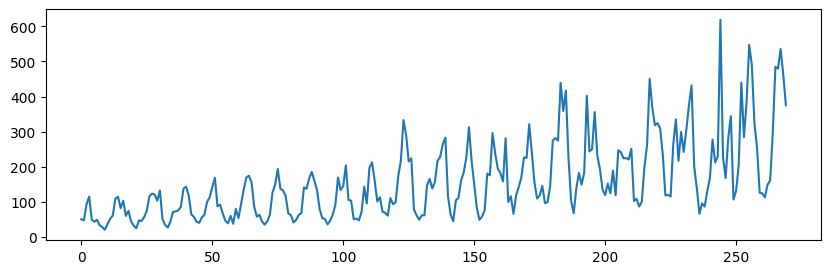

In [18]:
for lam in [-2, -1, 0, 1, 2]:
    print(f"lambda = {lam}")
    plot_box_cox(lam, df_train["y"])

Дисперсия выглядит лучше в окрестностях `lambda = 0`.

Попробуем подобрать lambda хитрее.

`Бонус (1 балл):` Предложите и реализуйте автоматический подбор параметра $\lambda$ (не обязательно с помощью максимизации логарифма правдоподобия). Для получения полного балла оно должно показать результат не хуже подобранной $\lambda$ на глаз.

Сохраните для последующих заданий и исходный ряд, и преобразованный рядом с оптимальным $\lambda$.

In [19]:
def search_box_cox_lambda(lam: float, y, verbose=False):
    transformed_data = box_cox(y, lam)
    transformed_data = (transformed_data - np.mean(transformed_data)) / np.std(
        transformed_data
    )

    if verbose:
        plt.figure(figsize=(10, 3))
        plt.plot(transformed_data)
        plt.title(f"λ = {lam}")
        plt.show()

    step = len(y) // 10
    vars = []
    for i in range(10):
        segment = transformed_data[i * step : (i + 1) * step]
        var = np.var(segment)
        vars.append(var)

    return np.mean(vars)

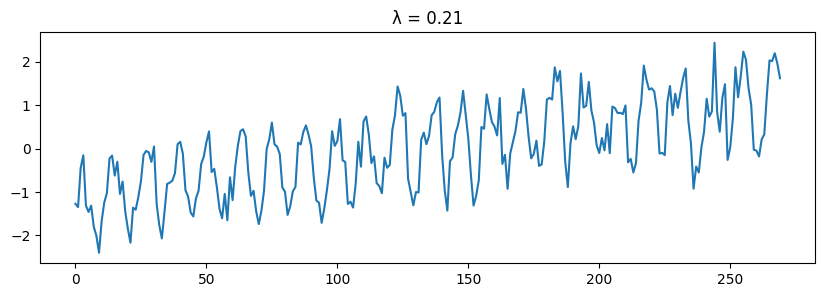

0.5224490778488843

In [20]:
vars = dict()
for lam in range(-200, 201):
    lam /= 100
    var = search_box_cox_lambda(lam, df_train["y"], False)
    vars[lam] = var
optimal_lambda = min(vars, key=vars.get)
optimal_value = vars[optimal_lambda]
search_box_cox_lambda(optimal_lambda, df_train["y"], True)

И еще один вариант, который мне предложил DEEPSEEK

In [21]:
fitted_data, fitted_lambda = stats.boxcox(df_train["y"])
print(f"Оптимальная λ методом максимального правдоподобия: {fitted_lambda:.3f}")

Оптимальная λ методом максимального правдоподобия: 0.107


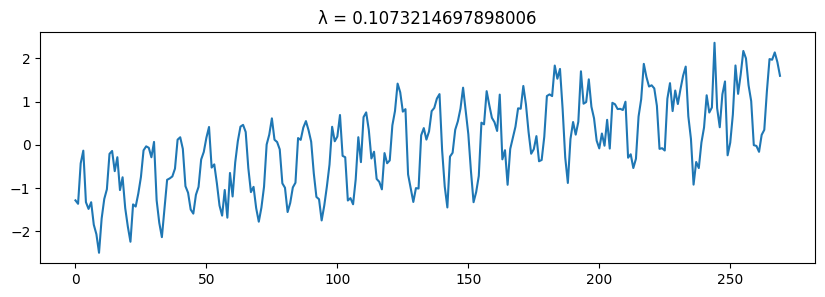

0.5225893348012662

In [22]:
search_box_cox_lambda(fitted_lambda, df_train["y"], True)

Дисперсия получилась почти одинаковой, но предпочту поверить библиотечной реализации :D

In [23]:
x_train_transformed = box_cox(df_train["y"], fitted_lambda)

### Задание 3. STL + простые модели (1.5 балла)

#### Задание 3.1: STL-декомпозиция (0.5 балла)

Примените STL-декомпозицию к преобразованному ряду, чтобы выделить тренд, сезонность и остатки (здесь можно воспользоваться [готовым методом](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html)).

Постройте графики для каждого из выделенных компонентов. 

In [24]:
x_train_series = pd.Series(
    np.array(x_train_transformed), index=df_train["date"], name="x_train"
)

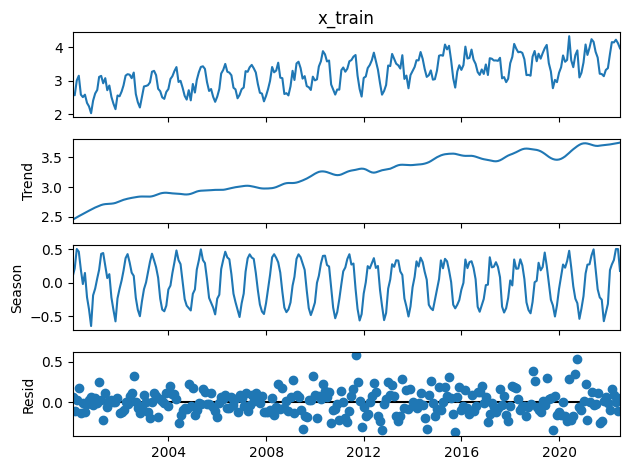

In [25]:
stl = STL(x_train_series, period=12)
res = stl.fit()
fig = res.plot()

`Ответьте на вопросы:` 
- Получилось ли выделить тренд и сезонность? Похожи ли остатки на шум? 

Остатки действительно похожи на шум, но похоже, что шум не аддитивный, а мультипликативный (дисперсия увеличивается со временем).

Что мы можем сказать о стационарности остатков? Подтвердите соответствующими [тестами](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html). Сделайте выводы.

In [26]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


adf_test(res.resid)

Results of Dickey-Fuller Test:
Test Statistic                -8.740087e+00
p-value                        3.025392e-14
#Lags Used                     1.400000e+01
Number of Observations Used    2.550000e+02
Critical Value (1%)           -3.456257e+00
Critical Value (5%)           -2.872942e+00
Critical Value (10%)          -2.572846e+00
dtype: float64


In [27]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


kpss_test(res.resid)

Results of KPSS Test:
Test Statistic            0.016406
p-value                   0.100000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\haker\AppData\Local\Temp\ipykernel_11192\4029286397.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Предположение о нестационарности не нашло отклика - оба теста показывают, что ряд остатков стационарен.

Что мы можем сказать об автокорреляции остатков? Постройте ACF и PACF для остатков. Сделайте выводы.

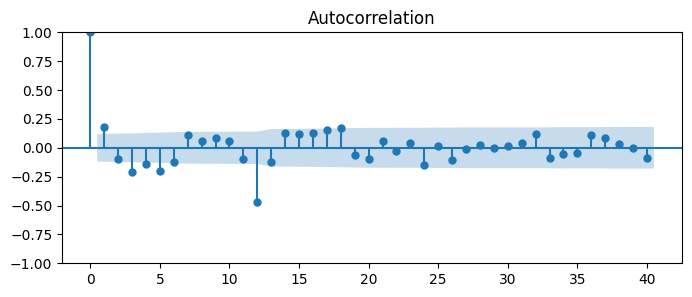

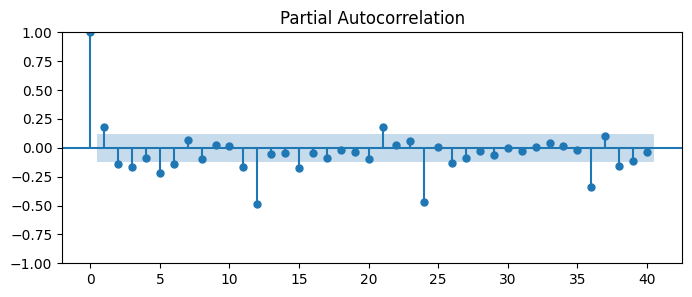

In [28]:
plot_acf_pacf(res.resid)

#### Задание 3.2: Прогнозирование с помощью простых моделей (1 балл)

Давайте теперь построим свой первый бейзлайн. Для тренда возьмем модель Хольта, для сезонности — наивный сезонный метод (**реализуйте его сами!**).

Для этого метода используем преобразованный ряд с оптимальным $\lambda$ из предыдущего задания.

In [29]:
class NaiveSeasonal:
    def __init__(self, seasonal_period: int):
        # --- Your code here ---
        self.seasonal_period = seasonal_period
        self.y = None

    def fit(self, y: np.ndarray):
        # --- Your code here ---
        self.y = y[-self.seasonal_period :]

    def predict(self, horizon: int) -> np.ndarray:
        # --- Your code here ---
        pred = []
        batch_count = int(np.ceil(horizon / self.seasonal_period))
        for batch in range(batch_count):
            for val in self.y:
                if horizon:
                    pred.append(val)
                    horizon -= 1
        return pd.Series(pred)

Не совсем, честно говоря, понял - имеется в виду, что надо взять ряд после преобразования, обе модели учить на нем и объединять прогнозы, или мы из прошлого задания - из STL берем из разложения тренд и сезонность и крутимся уже на них. Поэтому реализую оба варианта и сравним :D

In [30]:
ns = NaiveSeasonal(12)
ns.fit(x_train_transformed)

In [31]:
holt = Holt(x_train_transformed).fit()

Постройте прогноз на тестовую выборку.

In [32]:
forecast_period = len(df_test)

trend_forecast = holt.forecast(forecast_period)
seasonal_forecast = ns.predict(forecast_period).values

forecast = (trend_forecast + seasonal_forecast) / 2
forecast = inv_box_cox(forecast, fitted_lambda)

Нарисуйте соответствующий график. На нем должна быть видна история из тренировочной выборки, тестовая выборка и прогноз. Не забудьте сделать обратное преобразование!

Для графика продолжаю нагло арбузить DEEPSEEK

(промт типо "сделай красиво, пожалуйста", плюс сокращение лишнего после дипсика)

In [33]:
def plot_train_test_forecast(forecast, title):
    # Создаем график
    plt.figure(figsize=(12, 6))

    # 1. Обучающая выборка - синий
    plt.plot(
        df_train["date"].values,
        df_train["y"].values,
        label="Обучающая выборка",
        color="blue",
        linewidth=2,
        alpha=0.8,
    )

    # 2. Тестовая выборка - зеленый
    plt.plot(
        df_test["date"].values,
        df_test["y"].values,
        label="Фактические значения",
        color="green",
        linewidth=2,
        alpha=0.8,
    )

    # 3. Прогноз - красный
    plt.plot(
        df_test["date"].values,
        forecast.values,
        label="Прогноз",
        color="red",
        linewidth=2,
        linestyle="--",
        marker="o",
        markersize=4,
    )

    # Настройки графика
    plt.title(title)
    plt.xlabel("Дата", fontsize=12)
    plt.ylabel("Значение y", fontsize=12)
    plt.legend(loc="upper left", fontsize=11)
    plt.grid(True, alpha=0.3, linestyle="--")

    # Поворот дат для лучшей читаемости
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

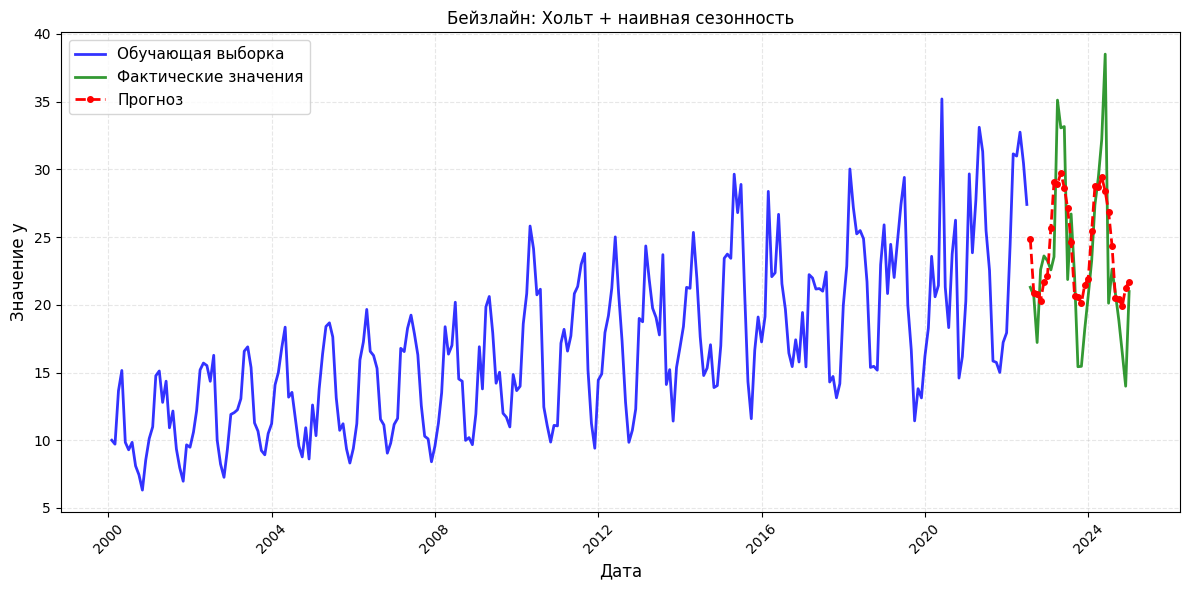

In [34]:
plot_train_test_forecast(forecast, title="Бейзлайн: Хольт + наивная сезонность")

In [35]:
def mae_mase_eval(forecast):
    print("MAE", mae(df_test["y"], forecast))
    print("MASE", mase(forecast.values, df_train["y"].values, df_test["y"].values, 12))

In [36]:
mae_mase_eval(forecast)

MAE 3.252649274908107
MASE 1.1275432006075823


А теперь вариант с STL

In [37]:
ns = NaiveSeasonal(12)
ns.fit(res.seasonal)

holt = Holt(res.trend.reset_index(drop=True)).fit()

trend_forecast = holt.forecast(forecast_period)
seasonal_forecast = ns.predict(forecast_period).values

forecast = trend_forecast + seasonal_forecast
forecast = inv_box_cox(forecast, fitted_lambda)

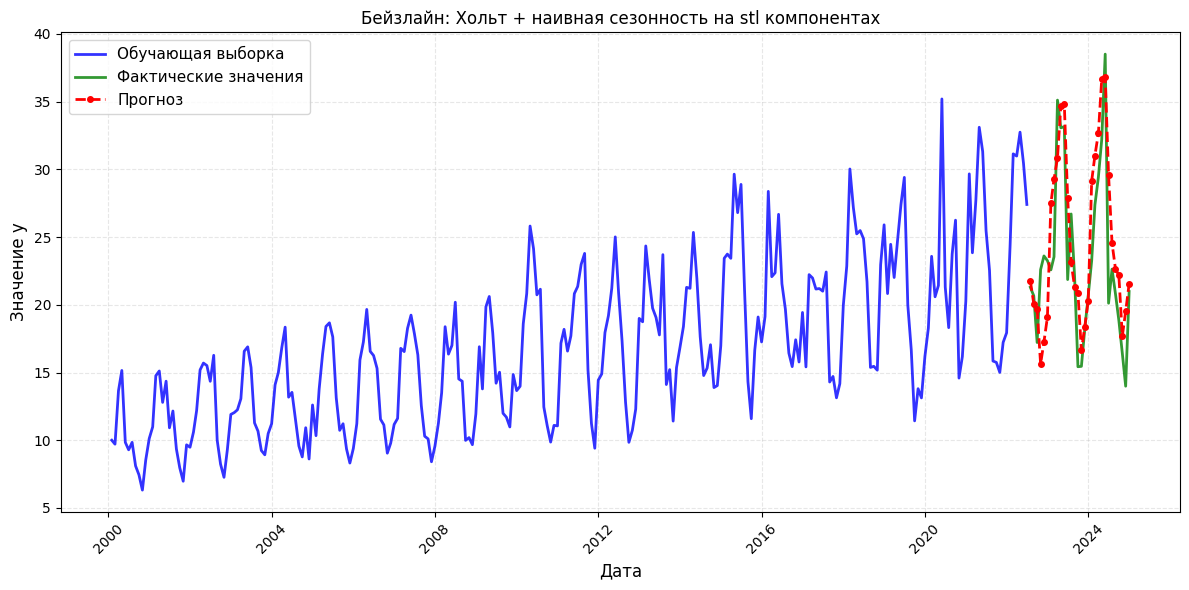

In [38]:
plot_train_test_forecast(
    forecast, title="Бейзлайн: Хольт + наивная сезонность на stl компонентах"
)

Тут явно симпатичнее, оставляем :D

Оцените прогноз при помощи метрик MAE, MASE

In [39]:
mae_mase_eval(forecast)

MAE 3.3205889375650113
MASE 1.1510947421990223


Визуально второй вариант выглядит значительно лучше, но цифоры получились обратные. Ну что могу сказать...

<img src="https://github.com/Aleksekek/HSE_TimeSeriesAnalysis/blob/main/HW_1/dogga.jpg?raw=true" alt="doggs" width="400"/>

__Здесь и в дальнейшем складывайте все метрики в словарь / датафрейм / еще куда-нибудь для удобства сравнения.__

In [40]:
metrics_dict = {
    "mae_baseline": mae(df_test["y"], forecast),
    "mase_baseline": mase(
        forecast.values, df_train["y"].values, df_test["y"].values, 12
    ),
}

### Задание 4: ETS модель (1.5 балла)

Исходя из экспериментов с бейзлайном, выберите подходящую [ETS](https://www.statsmodels.org/stable/generated/statsmodels.tsa.exponential_smoothing.ets.ETSModel.html) модель для ваших данных. Аргументируйте выбор.

__Обратите внимание, что моделировать нужно не преобразованный, а исходный ряд.__

Постройте прогноз на тестовую выборку.

Беру ETS(A,A,M) - ранее мы видели, что ошибка стационарна, поэтому ставлю ее аддитивной, тренд также выглядит аддитивным, а сезонность точно мультипликативна

In [41]:
train_series = pd.Series(
    df_train["y"].values, index=pd.DatetimeIndex(df_train["date"], freq="ME")
)

ets = ETSModel(train_series, error="add", trend="add", seasonal="mul").fit()

forecast = ets.forecast(forecast_period)

Нарисуйте соответствующий график. На нем должна быть видна история из тренировочной выборки, тестовая выборка и прогноз.

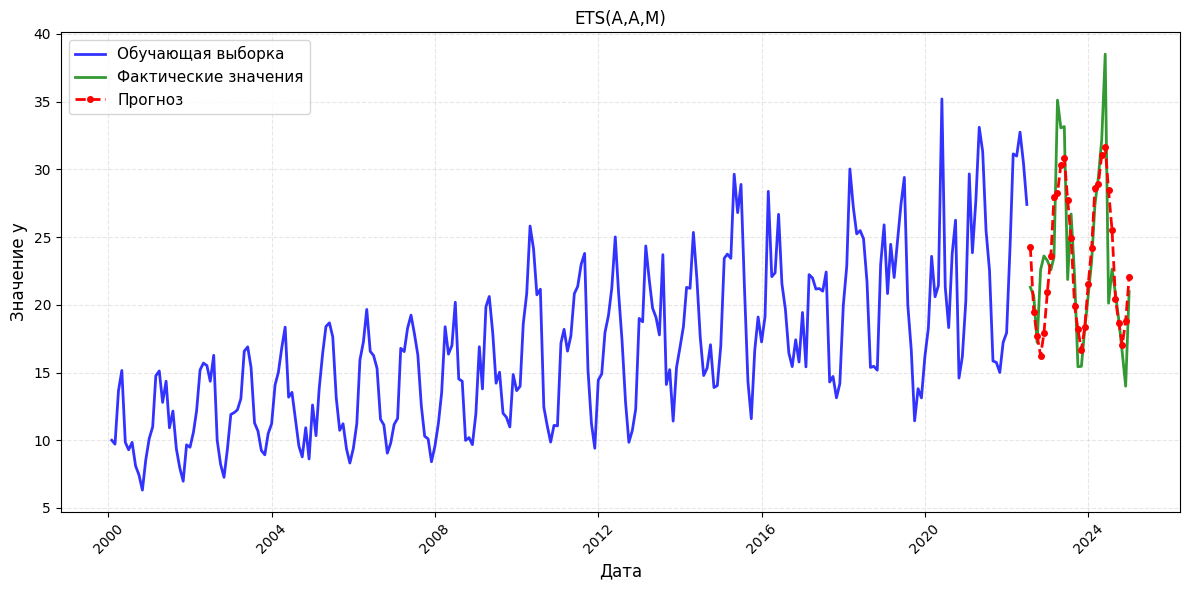

In [42]:
plot_train_test_forecast(forecast, title="ETS(A,A,M)")

Оцените прогноз при помощи метрик MAE, MASE

In [43]:
mae_mase_eval(forecast)

MAE 2.6762419186397772
MASE 0.9277294056330507


In [44]:
metrics_dict["mae_ets_aam"] = mae(df_test["y"], forecast)
metrics_dict["mase_ets_aam"] = mase(
    forecast.values, df_train["y"].values, df_test["y"].values, 12
)


Сравните вашу модель с тем, что выдает AutoETS из библиотеки [statsforecast](https://nixtlaverse.nixtla.io/statsforecast/index.html). Удалось ли вам побить AutoETS?

In [45]:
# Использую DEEPSEEK для корректной подготовки дф для подачи в модель
sf_train = pd.DataFrame(
    {"unique_id": 1, "ds": pd.to_datetime(df_train["date"]), "y": df_train["y"].values}
)

sf = StatsForecast(
    models=[AutoETS(season_length=12)],
    freq="ME",
)
sf.fit(sf_train)

StatsForecast(models=[AutoETS])

In [46]:
forecast = sf.predict(forecast_period)["AutoETS"]

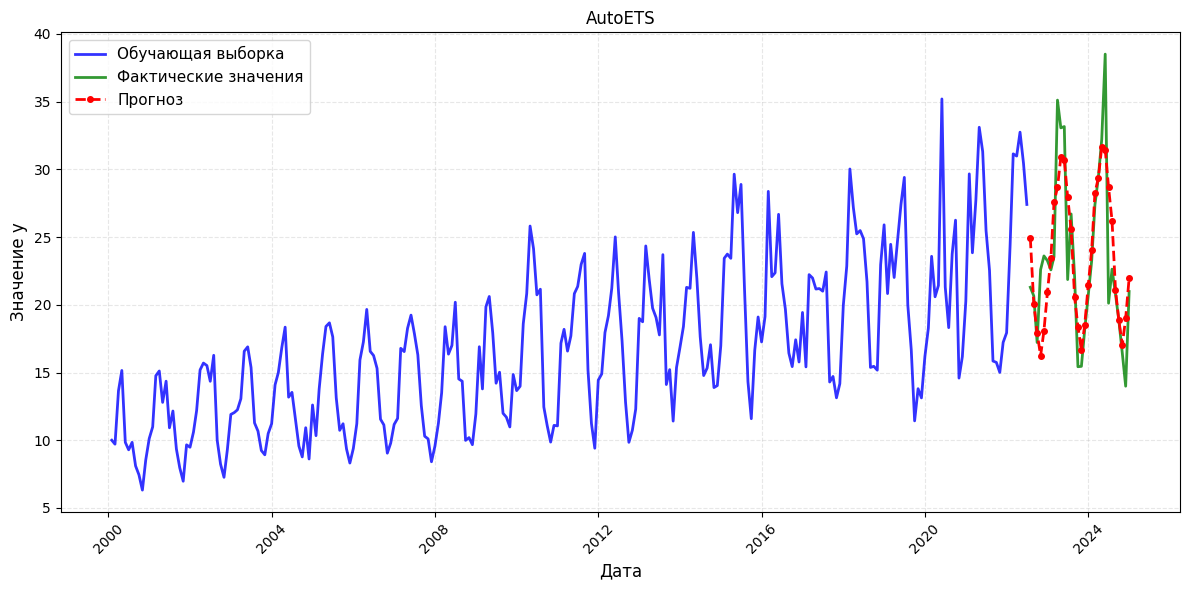

In [47]:
plot_train_test_forecast(forecast, title="AutoETS")

In [48]:
mae_mase_eval(forecast)

MAE 2.584818960618712
MASE 0.8960372906880735


In [49]:
metrics_dict["mae_autoets"] = mae(df_test["y"], forecast)
metrics_dict["mase_autoets"] = mase(
    forecast.values, df_train["y"].values, df_test["y"].values, 12
)

Подсказка: скорее всего у вас не получилось:) 

Если хотите побить AutoETS, попробуйте обратить внимание на вид остатков.

In [50]:
train_series = pd.Series(
    df_train["y"].values, index=pd.DatetimeIndex(df_train["date"], freq="ME")
)

ets = ETSModel(train_series, error="mul", trend="add", seasonal="mul").fit()

forecast = ets.forecast(forecast_period)

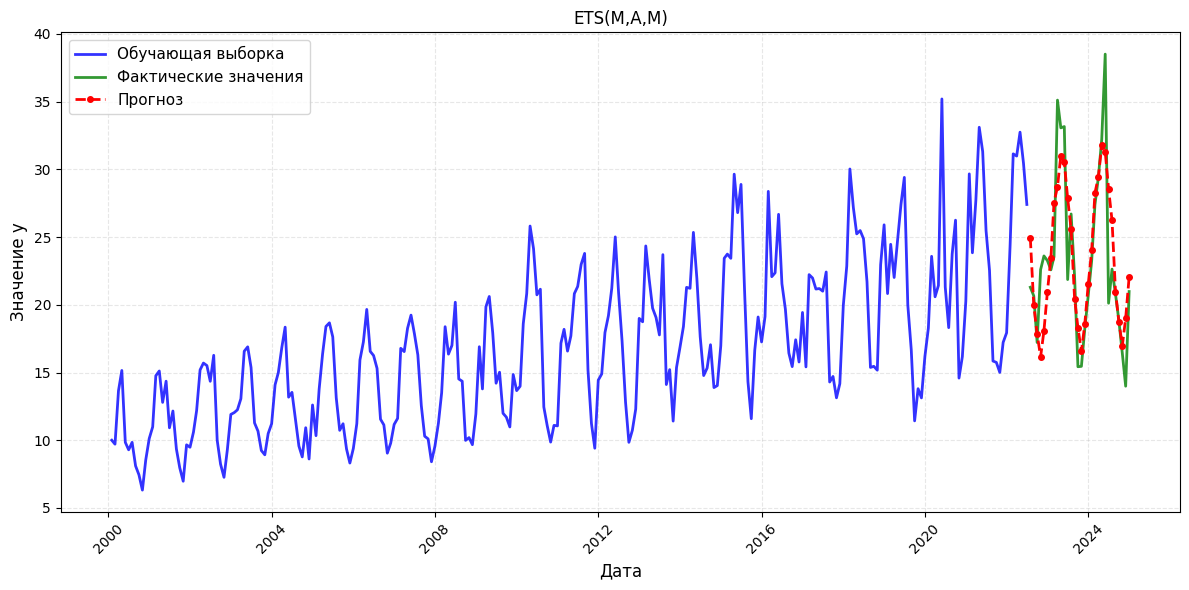

In [51]:
plot_train_test_forecast(forecast, title="ETS(M,A,M)")

In [52]:
mae_mase_eval(forecast)

MAE 2.579216076855438
MASE 0.894095029793298


Жыжнь - боль...   
Все таки предположение о мультипликативности остатков нашло отклик вот таким интересным образом - модель ETS(M,A,M) побила AutoETS. Ну ладно, принимаем к сведению и движемся дальше :D

<img src="https://github.com/Aleksekek/HSE_TimeSeriesAnalysis/blob/main/HW_1/dogga_2.jpg?raw=true" alt="doggs" width="400"/>

In [53]:
metrics_dict["mae_ets_mam"] = mae(df_test["y"], forecast)
metrics_dict["mase_ets_mam"] = mase(
    forecast.values, df_train["y"].values, df_test["y"].values, 12
)

### Задание 5: ARIMA модель (4 балла)

Самое время для SARIMA! Задание довольно сложное, поэтому мы готовы дать за него большое количество баллов. Мы в вас верим!

Пользуясь правилами [отсюда](https://docs.google.com/document/d/1wVsBkRIZbHdPMQIbUoXdznrmxkSZNEVFLq9D_OzCldA/edit?tab=t.0), подберите параметры [SARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html) модели, как мы делали это на занятии.

__Не забудьте, что здесь снова нужно моделировать преобразованный рядом с оптимальным $\lambda$ из задания 2.__

Помните, что начинаем мы с анализа сезонности и тренда, а затем уже подбираем параметры p, q, P, Q. И помните, что вам нужно будет несколько раз возвращаться к построению ACF, PACF графиков остатков, чтобы понять, хорошо ли вы смоделировали ряд. При правильно подобранных параметрах в остатках не должно быть автокорреляции и они должны проходить тесты на стационарность. 

Для удобства подбора параметров, повторно выведу ACF и PACF

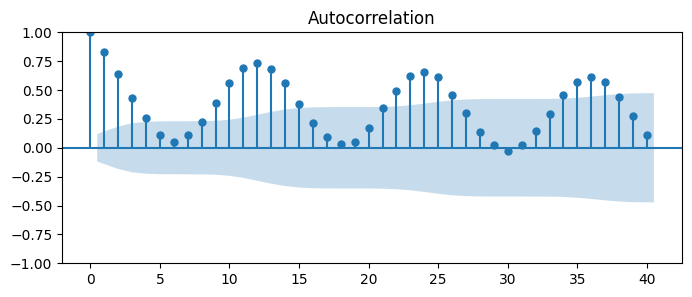

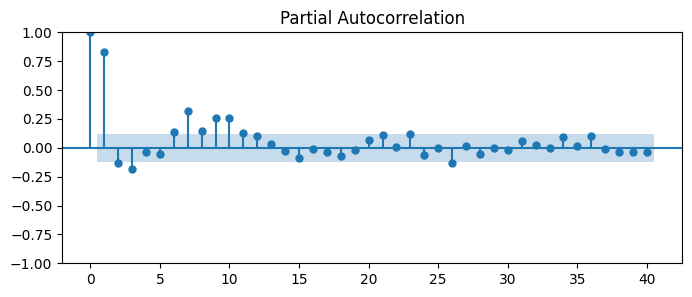

In [54]:
plot_acf_pacf(x_train_transformed)

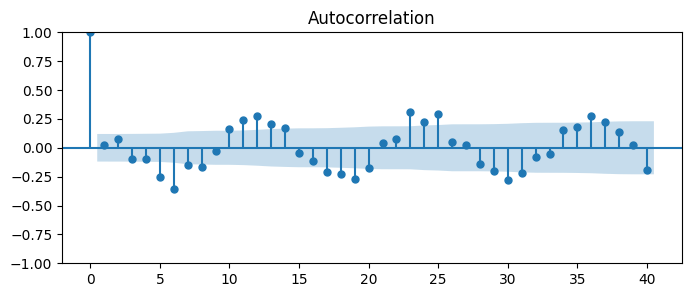

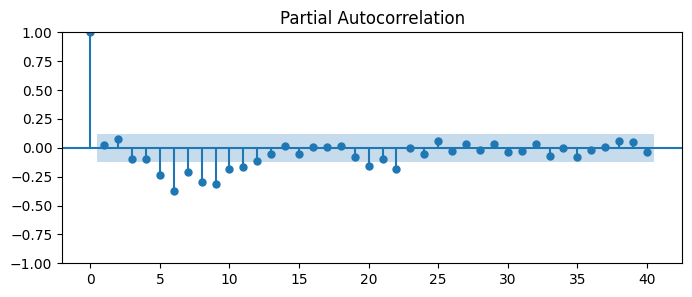

In [55]:
plot_acf_pacf(x_train_transformed.diff()[1:])

SARIMAX(p, d, q)x(P, D, Q, s) = 
```python
ARIMA(
    exog,
    order = (p, d, q),
    seasonal_order = (P, D, Q, s),
)
```

In [56]:
sarima = ARIMA(x_train_transformed, order=(1, 1, 0), seasonal_order=(1, 1, 1, 12)).fit()

forecast = sarima.forecast(forecast_period)

forecast = inv_box_cox(forecast, fitted_lambda)

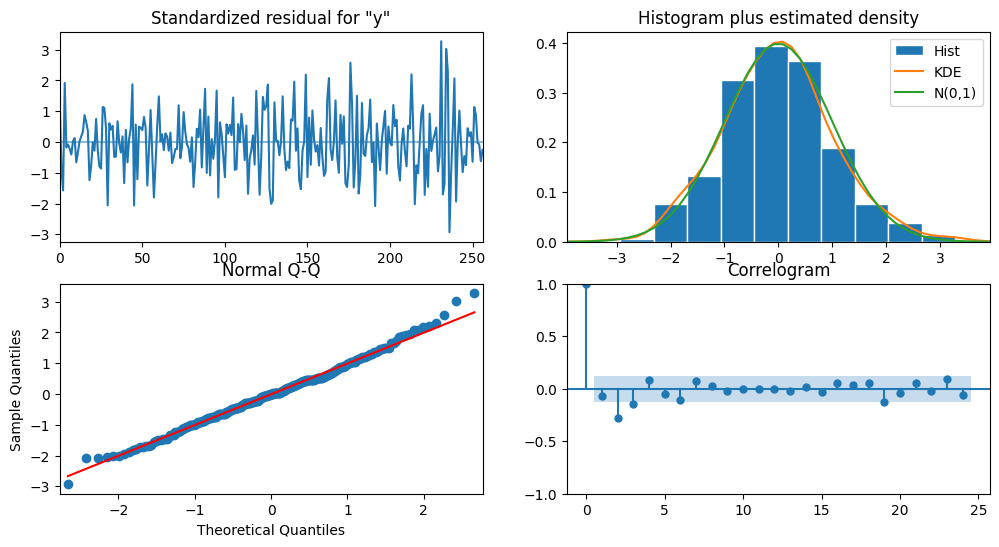

In [57]:
_ = sarima.plot_diagnostics(figsize=(12, 6), lags=24)

Итак, промежуточный вывод по подбору параметров SARIMA. Подберал изначально при помощи предоставленного документа, а потом добавил нотку творческих эксперементов.

Я оставил вариант `(1,1,0)(1,1,1,12)`. `MASE` такой модели `0.99`.

Немного дополнительно покрутив параметры, я получил улучшение `MASE` до `0.974` с параметрами `(0,1,1)(2,1,1,12)`, НО! Анализ такой модели показал, во-первых, чуть худший график остатков, заметно более слвинутый график с гистограммой и плоностью, а на графике ACF остатков осталась заметная положительная корреляция у первого лага вне доверительного интервала. Поэтому я полагаю, что это значительно больше похоже на оверфит, нежели на лучшие параметры. Качество у обеих моделей абсолютно сопоставимое, но первая модель значительно более простая по количеству параметров.

Нарисуйте соответствующий график. На нем должна быть видна история из тренировочной выборки, тестовая выборка и прогноз.

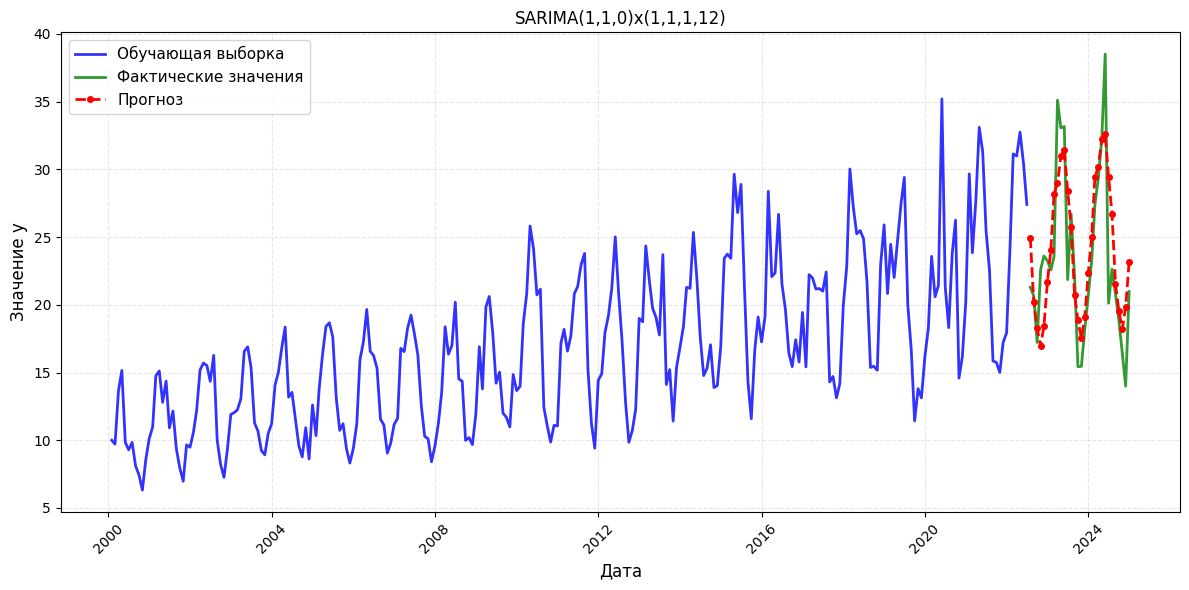

In [58]:
plot_train_test_forecast(forecast, "SARIMA(1,1,0)x(1,1,1,12)")

Оцените прогноз при помощи метрик MAE, MASE

In [59]:
mae_mase_eval(forecast)

MAE 2.8585458295066006
MASE 0.9909257473744655


In [60]:
metrics_dict["mae_arima"] = mae(df_test["y"], forecast)
metrics_dict["mase_arima"] = mase(
    forecast.values, df_train["y"].values, df_test["y"].values, 12
)


Сравните вашу модель с тем, что выдает AutoARIMA из библиотеки [statsforecast](https://nixtlaverse.nixtla.io/statsforecast/index.html). Удалось ли вам побить AutoARIMA?

In [61]:
sf_train = pd.DataFrame(
    {
        "unique_id": 1,
        "ds": pd.to_datetime(df_train["date"]),
        "y": x_train_transformed.values,
    }
)

sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq="ME",
).fit(sf_train)

In [62]:
forecast = inv_box_cox(sf.predict(forecast_period)["AutoARIMA"], fitted_lambda)

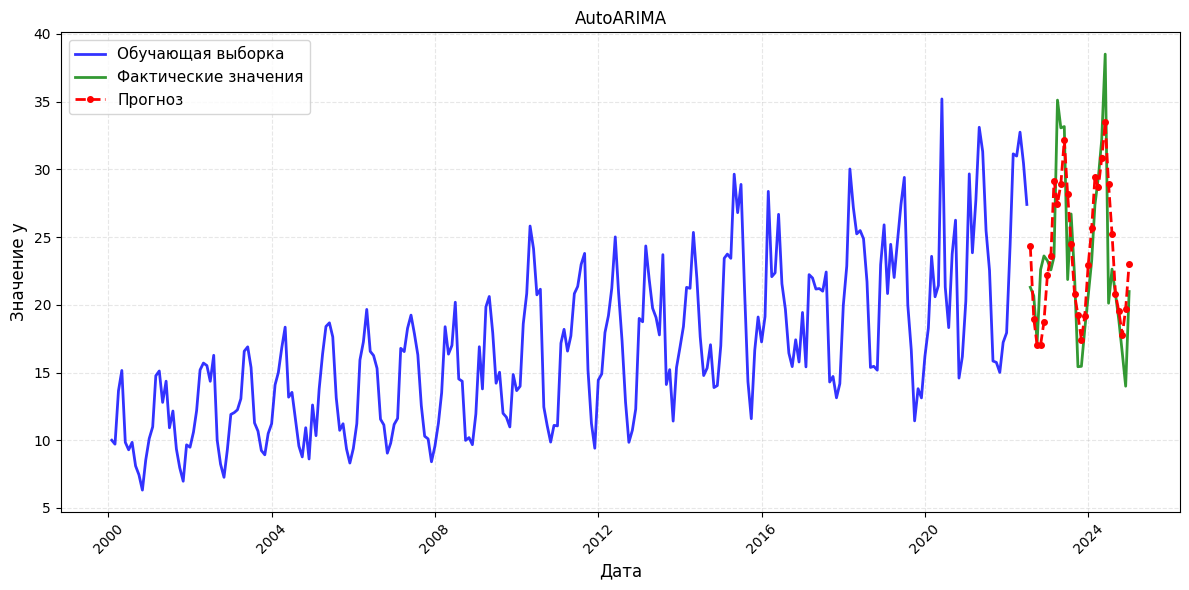

In [63]:
plot_train_test_forecast(forecast, "AutoARIMA")

In [64]:
mae_mase_eval(forecast)

MAE 2.91356261646498
MASE 1.0099975251196849


In [65]:
metrics_dict["mae_auto_arima"] = mae(df_test["y"], forecast)
metrics_dict["mase_auto_arima"] = mase(
    forecast.values, df_train["y"].values, df_test["y"].values, 12
)

Побить удалось =)  
(Сравнивать сложность итоговых моделей мы, конечно же, не будем)

Соберите все полученные метрики (и от автоматических решений тоже) в одну таблицу для удобства сравнения.

Воспользуюсь DEEPSEEK для распаршивания словарика, чтобы не мучаться самому с тем, что я тут насохранял :D

In [66]:
df = pd.DataFrame(list(metrics_dict.items()), columns=["metric", "value"])
df[["metric_type", "model"]] = df["metric"].str.split("_", n=1, expand=True)

# Создаем сводную таблицу
pivot_df = df.pivot(index="model", columns="metric_type", values="value")
pivot_df = pivot_df.sort_values("mase").reset_index()
pivot_df.columns.name = None  # Убираем имя колонок
pivot_df

,model,mae,mase
0,ets_mam,2.579216,0.894095
1,autoets,2.584819,0.896037
2,ets_aam,2.676242,0.927729
3,arima,2.858546,0.990926
4,auto_arima,2.913563,1.009998
5,baseline,3.320589,1.151095


`Бонус (0.5 баллов):` Добавьте в эту таблицу метрики бейзлайнов: последнее значение и прогноз модели SES.

In [67]:
ses = SimpleExpSmoothing(x_train_transformed, initialization_method="estimated").fit()

forecast = inv_box_cox(ses.forecast(forecast_period), fitted_lambda)

metrics_dict["mae_ses"] = mae(df_test["y"], forecast)
metrics_dict["mase_ses"] = mase(
    forecast.values, df_train["y"].values, df_test["y"].values, 12
)

In [68]:
forecast = pd.Series([df_train["y"].iloc[-1]] * 30)

metrics_dict["mae_last_val"] = mae(df_test["y"], forecast)
metrics_dict["mase_last_val"] = mase(
    forecast.values, df_train["y"].values, df_test["y"].values, 12
)

In [69]:
df = pd.DataFrame(list(metrics_dict.items()), columns=["metric", "value"])
df[["metric_type", "model"]] = df["metric"].str.split("_", n=1, expand=True)

pivot_df = df.pivot(index="model", columns="metric_type", values="value")
pivot_df = pivot_df.sort_values("mase").reset_index()
pivot_df.columns.name = None
pivot_df

,model,mae,mase
0,ets_mam,2.579216,0.894095
1,autoets,2.584819,0.896037
2,ets_aam,2.676242,0.927729
3,arima,2.858546,0.990926
4,auto_arima,2.913563,1.009998
5,baseline,3.320589,1.151095
6,last_val,6.508097,2.256057
7,ses,6.508097,2.256057


Какая модель показала наилучший результат? Удалось ли побить самые простые модели? А автоматические методы?

Победила MAMа 😇

Побить получилось и самые простые модели, и автоматические методы. По крайней мере, по скору =)  
Лучший результат показала ETS(M,A,M) - по сути, модель, потребовавшая значительно меньше усилий, нежели SARIMA. Хотя скор всё ещё не настолько хорош, насколько бы нам хотелось, результаты достигнуты в целом неплохие.

### БОНУС: Улучшите ваше решение из прошлых заданий (до 2-х бонусных баллов)

Скомбинируйте методы: сезонность из STL, ARIMA на всем остальном (или только на остатках). Либо же ETS на всем ряде + ARIMA на остатках. Будет еще круче, если вы попробуете что-то свое. Можете попробовать другие модели (Prophet, Theta, ...), но не лезьте пока что в сторону машинного обучения.

#### ETS + ARIMA

In [70]:
ets_model = ETSModel(train_series, error="mul", trend="add", seasonal="mul").fit()
ets_forecast = ets_model.forecast(forecast_period)

In [71]:
ets_residuals = train_series - ets_model.fittedvalues

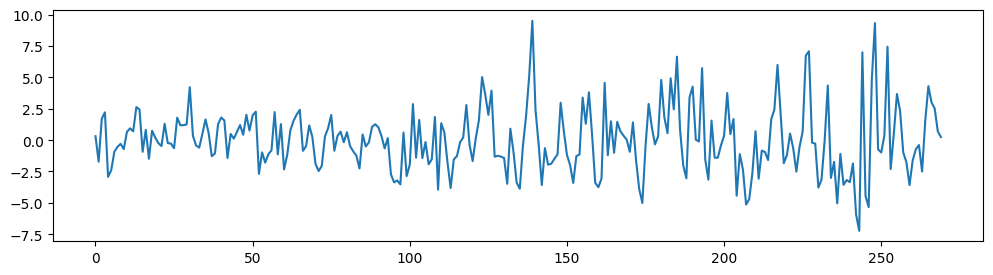

In [72]:
fig = plt.figure(figsize=(12, 3))
plt.plot(ets_residuals.reset_index(drop=True))
plt.show()

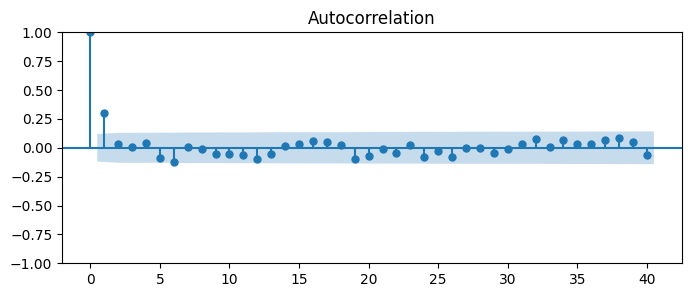

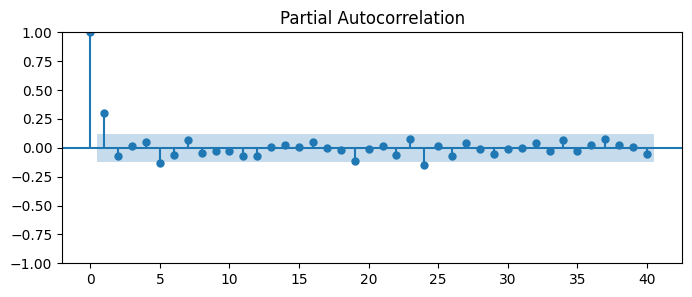

In [73]:
plot_acf_pacf(ets_residuals)

In [74]:
arima_resid = ARIMA(ets_residuals, order=(0, 0, 0), seasonal_order=(1, 1, 1, 14)).fit()
resid_forecast = arima_resid.forecast(forecast_period)

forecast = ets_forecast + resid_forecast

Интересно, что при моделировании ошибок смещение сезонности до 14 дает лучший результат. Долго вглядывался в графики в поисках значения, в итоге просто перебрал несколько в окрестности 16 и получил такой результат.

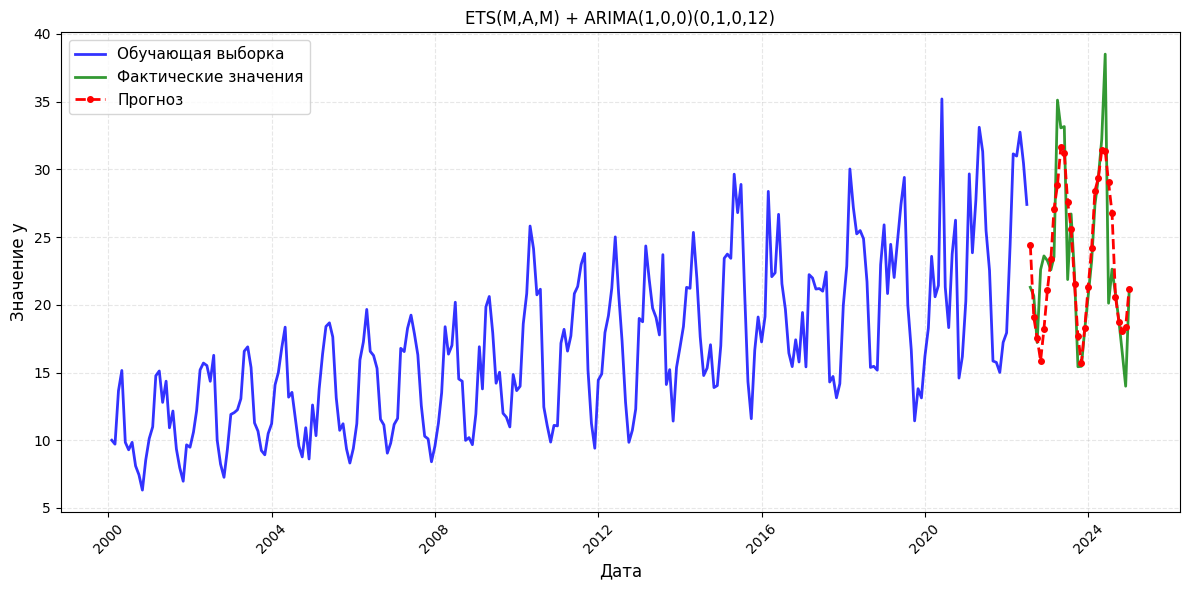

In [ ]:
plot_train_test_forecast(forecast, "ETS(M,A,M) + ARIMA(0,0,0)(1,1,1,14)")

In [76]:
mae_mase_eval(forecast)

MAE 2.4538012625258774
MASE 0.850619509009781


Скор то улучшился, но стоили ли мучения с переподбором параметров ARIMA под новый ряд и общее усложнение модели этих пары процентов - вопрос дискусионный :D

In [77]:
metrics_dict["mae_ets+arima"] = mae(df_test["y"], forecast)
metrics_dict["mase_ets+arima"] = mase(
    forecast.values, df_train["y"].values, df_test["y"].values, 12
)

#### Theta

In [78]:
theta = ThetaModel(df_train["y"], period=12, deseasonalize=True).fit()

forecast = theta.forecast(forecast_period)

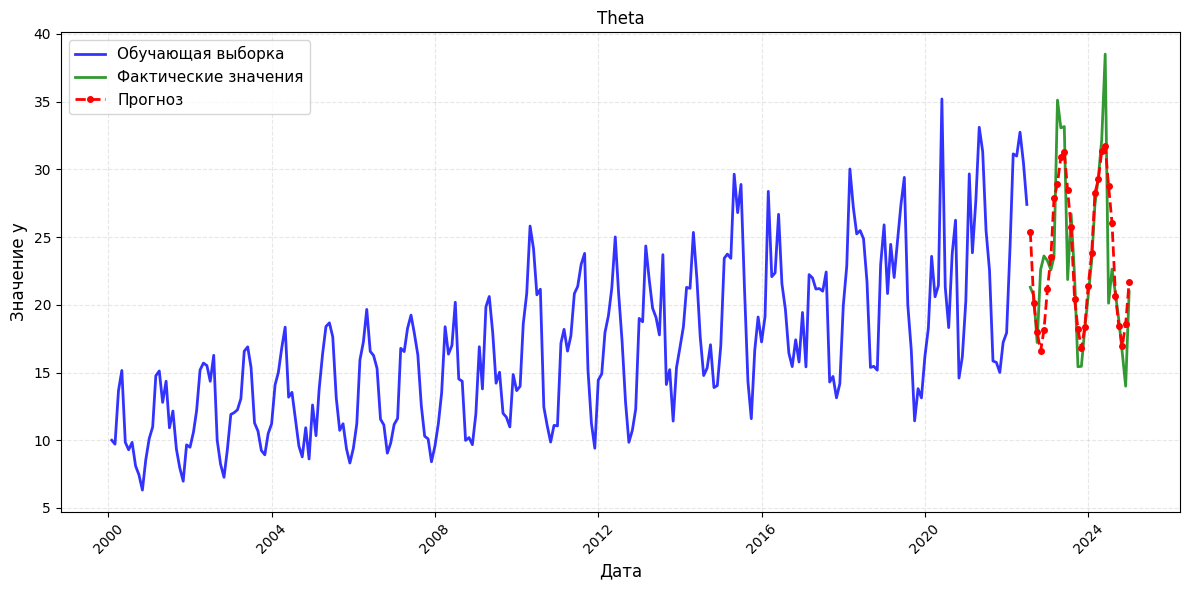

In [79]:
plot_train_test_forecast(forecast, "Theta")

In [80]:
mae_mase_eval(forecast)

MAE 2.5487120568666466
MASE 0.883520695635942


In [81]:
metrics_dict["mae_theta"] = mae(df_test["y"], forecast)
metrics_dict["mase_theta"] = mase(
    forecast.values, df_train["y"].values, df_test["y"].values, 12
)

#### Prophet

In [82]:
df_prophet = pd.DataFrame({"ds": df_train["date"], "y": df_train["y"]})

# Настройка модели
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
).fit(df_prophet)

20:48:39 - cmdstanpy - INFO - Chain [1] start processing
20:48:39 - cmdstanpy - INFO - Chain [1] done processing


In [83]:
future = model.make_future_dataframe(periods=forecast_period, freq="ME")
forecast = model.predict(future)["yhat"][270:]

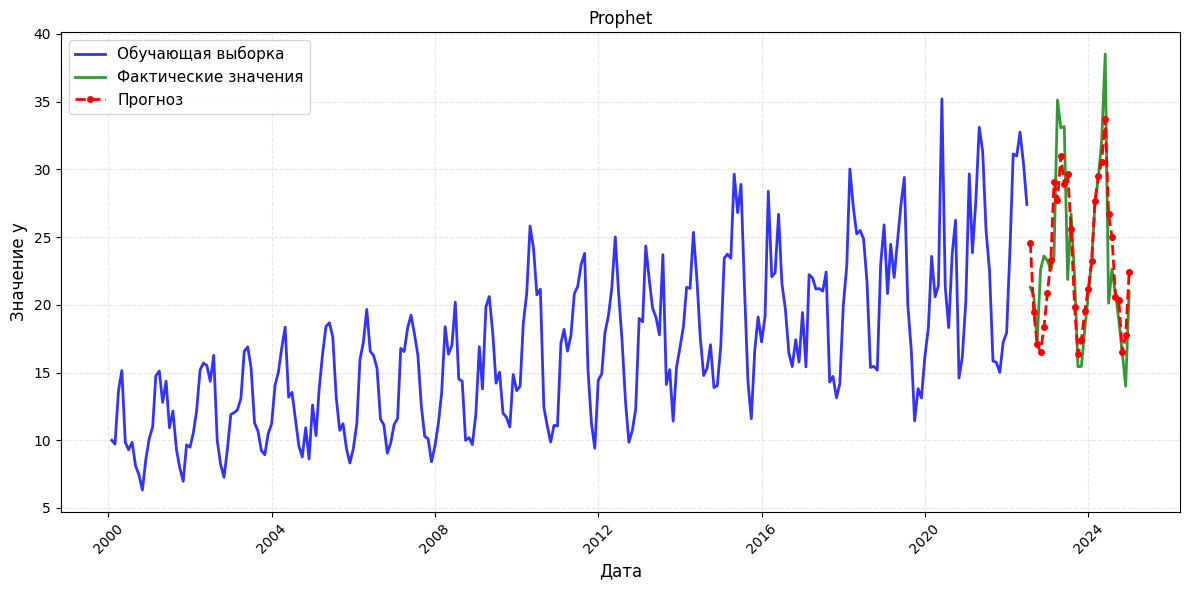

In [84]:
plot_train_test_forecast(forecast, "Prophet")

In [85]:
mae_mase_eval(forecast)

MAE 2.570136492770882
MASE 0.8909475575534035


In [86]:
metrics_dict["mae_prophet"] = mae(df_test["y"], forecast)
metrics_dict["mase_prophet"] = mase(
    forecast.values, df_train["y"].values, df_test["y"].values, 12
)

#### Итоговая сводная таблица

In [87]:
df = pd.DataFrame(list(metrics_dict.items()), columns=["metric", "value"])
df[["metric_type", "model"]] = df["metric"].str.split("_", n=1, expand=True)

pivot_df = df.pivot(index="model", columns="metric_type", values="value")
pivot_df = pivot_df.sort_values("mase").reset_index()
pivot_df.columns.name = None
pivot_df

,model,mae,mase
0,ets+arima,2.453801,0.850620
1,theta,2.548712,0.883521
2,prophet,2.570136,0.890948
3,ets_mam,2.579216,0.894095
4,autoets,2.584819,0.896037
5,ets_aam,2.676242,0.927729
6,arima,2.858546,0.990926
7,auto_arima,2.913563,1.009998
8,baseline,3.320589,1.151095
9,last_val,6.508097,2.256057


### Вывод по доп экспериментам

Главный вывод - да, скор удалось улучшить. Каждый из дополнительно опробованных методов дал лучший скор, чем все предыдущие модели.

И всё же... Стоит ли оно того?

Самый простой и все ещё настолько же сопоставимый со всеми остальными результат мы получили с помощью ETS(M,A,M). Улучшили ли скор? Да *(на 4%)*. Но ценой усложнения как собственной работы, так и используемых моделей. 

Если мы говорим о каком-нибудь хакатоне или любой другой ситуации "лучший скор любой ценой", то усилия найдут отклик, для более бытовых и рабочих ситуаций мы наблюдаем подтверждение прекрасного выражения: "20% усилий дают 80% результата".

### БОНУС: Повторите задания из этого ноутбука на реальном датасете (до 4-х бонусных баллов)

Баллы за это задание ставится при условии, что вы подробно опишите, что вы делали и почему И если вы побили Auto-ETS и Auto-ARIMA модели на отложенном тесте в 10% точек.

Будем работать с датасетом `NN5`, который можно скачать [здесь](https://zenodo.org/records/4656117). Временные ряды в этом датасете представляют собой данные по ежедневным снятиям наличных в банкоматах в Великобритании. 

Заберем из него ряд под номером 92.

In [88]:
df_real = pd.read_csv("nn5.csv")
df_real = df_real[df_real["id"] == 92]

In [89]:
# --- Your code here ---